<a href="https://colab.research.google.com/github/Raiyan01/HW1/blob/main/Ryan_Belo_PokemonClassification_G_Atkin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task for Today  

***

## Fire/Water Pokémon Classification  

Given *images of Pokémon*, let's try to predict the **type** of a given Pokémon.  
  
We will use a TensorFlow CNN to make our predictions.

# Getting Started

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
import matplotlib.image as mpimg

import os
from pathlib import Path
import re

import tensorflow as tf

In [ ]:
train_dir = '../input/pokemon-images-and-types/images/images'
train_path = Path(train_dir)

In [ ]:
files = list(train_path.glob('*.png'))
names = [os.path.split(x)[1] for x in list(train_path.glob('*.png'))]

image_df = pd.concat([pd.Series(names, name='Name'), pd.Series(files, name='Filepath').astype(str)], axis=1)
image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x))
image_df

,Name,Filepath
0,throh,../input/pokemon-images-and-types/images/image...
1,samurott,../input/pokemon-images-and-types/images/image...
2,venomoth,../input/pokemon-images-and-types/images/image...
3,latios,../input/pokemon-images-and-types/images/image...
4,shinx,../input/pokemon-images-and-types/images/image...
...,...,...
716,audino,../input/pokemon-images-and-types/images/image...
717,shieldon,../input/pokemon-images-and-types/images/image...
718,gigalith,../input/pokemon-images-and-types/images/image...
719,ledyba,../input/pokemon-images-and-types/images/image...


In [ ]:
label_df = pd.read_csv('../input/pokemon-images-and-types/pokemon.csv')
label_df

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


In [ ]:
# Merging dfs
train_df = image_df.merge(label_df, on='Name')
train_df = train_df.drop(['Name', 'Type2'], axis=1)
train_df

,Filepath,Type1
0,../input/pokemon-images-and-types/images/image...,Fighting
1,../input/pokemon-images-and-types/images/image...,Water
2,../input/pokemon-images-and-types/images/image...,Bug
3,../input/pokemon-images-and-types/images/image...,Dragon
4,../input/pokemon-images-and-types/images/image...,Electric
...,...,...
716,../input/pokemon-images-and-types/images/image...,Normal
717,../input/pokemon-images-and-types/images/image...,Rock
718,../input/pokemon-images-and-types/images/image...,Rock
719,../input/pokemon-images-and-types/images/image...,Bug


In [ ]:
# Limiting data to Fire and Water types
train_df = train_df.query("Type1 == 'Fire' | Type1 == 'Water'")
train_df

,Filepath,Type1
1,../input/pokemon-images-and-types/images/image...,Water
7,../input/pokemon-images-and-types/images/image...,Water
10,../input/pokemon-images-and-types/images/image...,Water
19,../input/pokemon-images-and-types/images/image...,Water
35,../input/pokemon-images-and-types/images/image...,Fire
...,...,...
696,../input/pokemon-images-and-types/images/image...,Water
701,../input/pokemon-images-and-types/images/image...,Fire
704,../input/pokemon-images-and-types/images/image...,Fire
707,../input/pokemon-images-and-types/images/image...,Fire


# Load Image Data

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255
)

In [ ]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    seed=1,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    seed=1,
    subset='validation'
)

Found 122 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


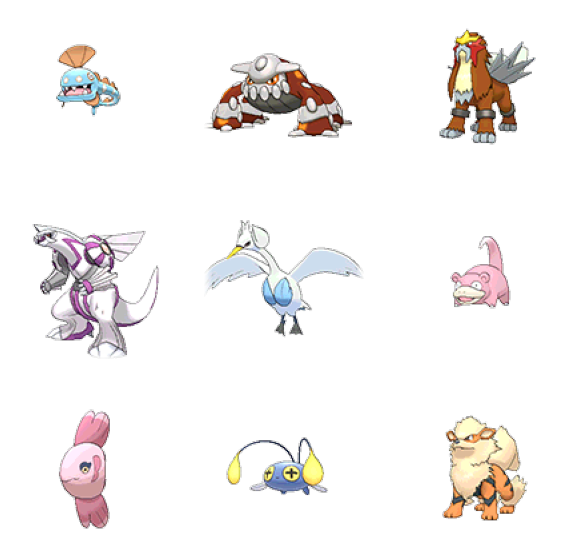

In [ ]:
image_sample = train_data.next()[0]

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_sample[i, :, :, :])
    plt.axis('off')
plt.show()

# Feature Extraction

In [ ]:
inputs = tf.keras.Input(shape=(120, 120, 4))

conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(8, 8), activation='relu')(inputs)
pool1 = tf.keras.layers.MaxPool2D()(conv1)

conv2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(8, 8), activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPool2D()(conv2)

conv3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(8, 8), activation='relu')(pool2)
pool3 = tf.keras.layers.MaxPool2D()(conv3)

outputs = tf.keras.layers.GlobalAveragePooling2D()(pool3)


feature_extractor = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
feature_extractor.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 4)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 113, 113, 64)      16448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 49, 49, 128)       524416    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 17, 17, 256)       2097408   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 256)        

# Classification

In [ ]:
clf_inputs = feature_extractor.input
clf_outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(feature_extractor.output)

classifier = tf.keras.Model(inputs=clf_inputs, outputs=clf_outputs)

In [ ]:
classifier.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 4)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 113, 113, 64)      16448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 49, 49, 128)       524416    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 17, 17, 256)       2097408   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 256)        

# Training

In [ ]:
classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = classifier.fit(
    train_data,
    validation_data=val_data,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100
4/4 [==============================] - 0s 73ms/step - loss: 0.7736 - accuracy: 0.6230 - val_loss: 0.6866 - val_accuracy: 0.7000
Epoch 2/100
4/4 [==============================] - 0s 44ms/step - loss: 0.6884 - accuracy: 0.6639 - val_loss: 0.6814 - val_accuracy: 0.8667
Epoch 3/100
4/4 [==============================] - 0s 43ms/step - loss: 0.6737 - accuracy: 0.7787 - val_loss: 0.7261 - val_accuracy: 0.7000
Epoch 4/100
4/4 [==============================] - 0s 45ms/step - loss: 0.6595 - accuracy: 0.7787 - val_loss: 0.6570 - val_accuracy: 0.7000
Epoch 5/100
4/4 [==============================] - 0s 41ms/step - loss: 0.5711 - accuracy: 0.7705 - val_loss: 0.3517 - val_accuracy: 0.9333
Epoch 6/100
4/4 [==============================] - 0s 41ms/step - loss: 0.5486 - accuracy: 0.7705 - val_loss: 0.5069 - val_accuracy: 0.7333
Epoch 7/100
4/4 [==============================] - 0s 40ms/step - loss: 0.4984 - accuracy: 0.7705 - val_loss: 0.4475 - val_accuracy: 0.8333
Epoch 8/100
4/4 [===

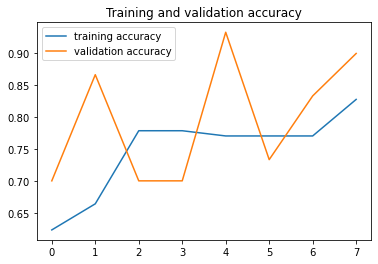

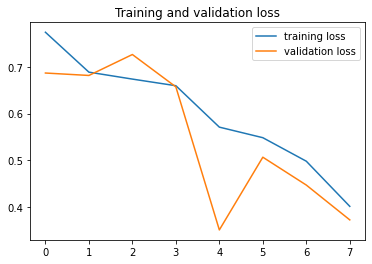

In [ ]:
#retrieve accuracy history on training and validation data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# retrieve loss history on training and validation data
loss = history.history['loss']
val_loss = history.history['val_loss']

# get number of epochs
epochs = range(len(acc))

# plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

# Visualizing Extracted Features

In [ ]:
feature_extractor.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 4)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 113, 113, 64)      16448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 49, 49, 128)       524416    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 17, 17, 256)       2097408   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 256)        

In [ ]:
feature_extractor.layers

In [ ]:
feature_extractor.layers[1].weights[0].shape

TensorShape([8, 8, 4, 64])

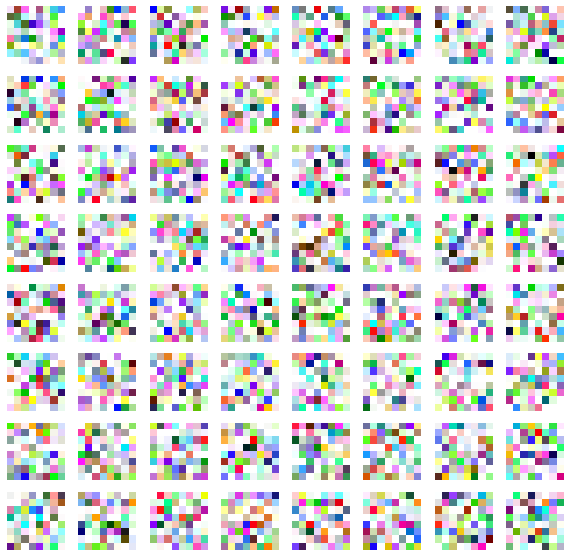

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    img = feature_extractor.layers[1].weights[0][:, :, :, i].numpy().copy()
    for channel in range(4):
        img[:, :, channel] = minmax_scale(img[:, :, channel])
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
# get true labels
true_labels = val_data.labels

# get predictions in the form of probablities 
predictions = classifier.predict(val_data)

# convert probablities into binary values 
predictions = [1 if n >= 0.5 else 0 for n in predictions]
print("Model predictions: "+str(predictions))
print("Actual labels:     "+str(true_labels))

# determine filepaths of misclassified pokemon
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred, label, i in zip(predictions, true_labels, range(len(predictions))):
  misclassified_filepaths.append(val_data.filepaths[i])
  if pred != label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of misclassified pokemon: "+str(num_misclasssified))

Model predictions: [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]
Actual labels:     [1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
# of misclassified pokemon: 14


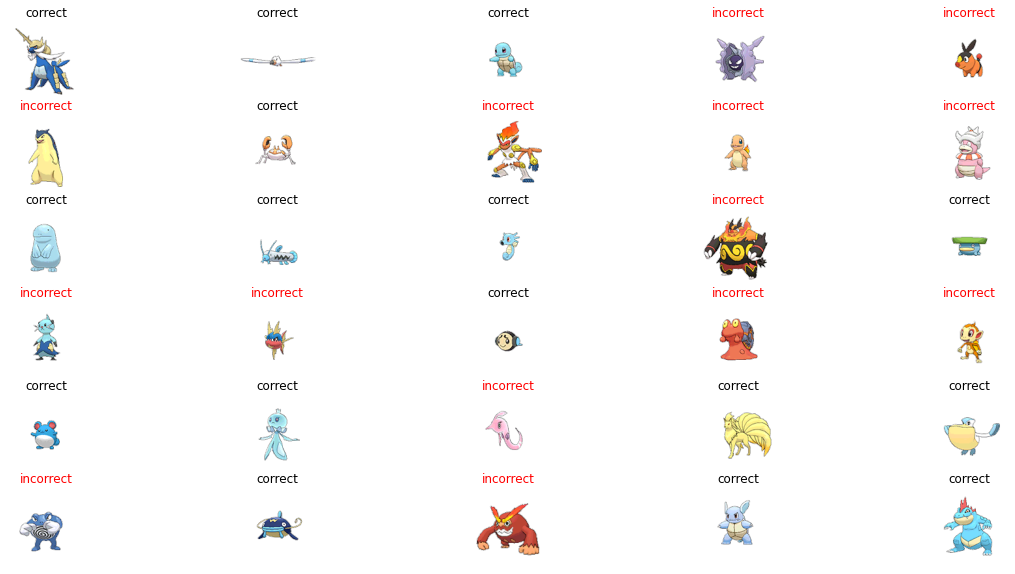

In [ ]:
# obtain the images from the filepath at the determined indices
misclassified_imgs = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))

# plot results
f, axarr = plt.subplots(6,5, figsize=(20,10))  
count = 0
for r in range(6):
  for c in range(5):
    axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
      axarr[r,c].set_title(correctness[count])
    else:
      axarr[r,c].set_title(correctness[count], color='red')
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()

# Data Every Day  

This notebook is featured on Data Every Day, a YouTube series where I train models on a new dataset each day.  

***

Check it out!  
https://youtu.be/ioNBmzKJiUE